## Standard imports

In [1]:
%matplotlib inline
import cv2
import math
from matplotlib import pyplot as plt
from matplotlib import mlab
from matplotlib import cm
from matplotlib import colors
import numpy as np;
import scipy.optimize
from scipy.optimize import curve_fit
from scipy.interpolate import UnivariateSpline
import functools
import queue
import copy
import time
from pylab import savefig
import plotly.plotly
from plotly.graph_objs import *
import csv

### Files and locations

In [2]:
# Z series for calibration
file_path_z_series = '/Users/cyamanishi3/Desktop/201902/Processed/zStack147/'
#file_path_z_series = 'E:/GT_rehydration_images/20180719/SingleParticle2/'
#file_path_d5p5diluent = 'E:/GT_rehydration_images/20180718/5%PEGdiluent_5%DEX_n0001/'
#trace_file_path = '/Users/cyamanishi3/Desktop/201902/Processed/filter146/'

### Particle class object that defines how the tracked object data is stored

In [3]:
class Particle(object):
    def __init__(self, ID, x, y, z, time):
        self.ID = ID
        self.Positions = []
        self.Positions.append([time, x, y, z])
        self.Age = 0
    def addpos(self,x,y,z,time):
        self.Positions.append([time, x, y, z])
    def getpos(self):
        return (self.Positions[-1][1],self.Positions[-1][2])    
    def getid(self):
        return (self.ID)
    def print_particles(self):
        print("ID:",self.ID,"\n")
        print("Positions:",self.Positions,"\n")
    def print_position(self, i):
        print(self.Positions[i])

In [4]:
class Calibration(object):
    def __init__(self):
        self.w = []
        self.h = []
        self.z = []
    def addshape(self, w, h, z):
        self.w.append(w)
        self.h.append(h)
        self.z.append(z)
    def getshape(self):
        return (self.Shapes[-1][0],self.Shapes[-1][1])
    def print_shape(self, i):
        print(self.Shapes[i])

### Iterate through the images detecting and linking the particles

In [5]:
def findxy(cnt):
    #(x, y), _,_ = cv2.fitEllipse(cnt)
    (x, y), _ = cv2.minEnclosingCircle(cnt)
    #print("Circle center: x {}, y {}".format(x, y))
    return [x, y]

In [6]:
# Crop around a found particle and run a 2D Gaussian fit 
# Take in a center position and source image
def fitFWHM(roi, ax):
    tots = np.sum(roi, axis=ax)
    pixel_arr = np.linspace(0,len(tots)-1,len(tots))
    base = tots - np.min(tots)
    spline = UnivariateSpline(pixel_arr, base-np.percentile(base,95)/2, s=1)
    roots = spline.roots()
    
    # Show debug plots
    if False:
        pixel_arr_hd = np.linspace(0,len(tots)-1,1000)
        plt.plot(pixel_arr, base, '-')
        plt.plot(pixel_arr_hd, spline(pixel_arr_hd),'r-')
        plt.tick_params('both', bottom='off', top='off', right='off', left='off')
        plt.xlabel('Pixel number')
        plt.legend(('Intensity', 'Spline fit'))
        plt.plot(pixel_arr_hd, np.zeros(len(pixel_arr_hd)),'k-')
    if len(roots) != 2:
        #print('Noisy Gaussian fit')
        #print(roots)
        #plt.subplot(1,3,1)
        #plt.imshow(roi)
        #plt.figure(num=None, figsize=(33, 10), dpi=80, facecolor='w', edgecolor='k')
        if len(roots) is 1:
            return 0
        if len(roots) <1:
            #print('No spline roots')
            return np.NaN
        std = np.max(roots)-roots[0]
    else:
        std = roots[1]-roots[0]
    #plt.legend(('Data', 'Fit'))
    return std

def fit2D(img, x, y, xspan=6, yspan=6):
    # Crop the image around the particle
    plotBool = False
    roi = img[np.int(y-yspan):np.int(y+yspan), np.int(x-xspan):np.int(x+xspan)]
    if plotBool:
        plt.figure()
        plt.subplot(1,3,1)
        plt.title('Region of interest intensity heatmap')
        plt.imshow(roi)
        plt.tick_params('both', bottom='off', top='off', right='off', left='off')
        plt.subplot(1,3,2)
        plt.title('Spline fit along x')
    w = fitFWHM(roi, 0)
    if plotBool:
        plt.subplot(1,3,3)
        plt.title('Spline fit along y')
    h = fitFWHM(roi, 1)
    return [w, h]


### Calibrate the z position 

In [7]:
# Use linear fit to w and to h
#Read image and obtain threshold. Fit ellipse.
#Find minimum width and index it to z position. Do the same for height.
#Set up function to back-calculate z from

def collect_calibration(file_path_z_series, cal_dat=None, offset=0,
                        intensity_thresh = 3,    
                        positions = 32,
                        min_position = 7,
                        step_size = 5.55):
    step = (positions-min_position)*step_size/2+offset
    cal_pos = []
    cal_w = []
    cal_h = []
    if cal_dat is None:
        cal_dat = Calibration()
    
    for pos in range(min_position, positions):#range(1, positions):
        #Read in the images according to the file name
        file_type = '.tif'
        file_path_complete = file_path_z_series+str(pos).zfill(5)+file_type
        img = cv2.imread(file_path_complete,0)
        show_images = False
        
        ret,thresh = cv2.threshold(img,intensity_thresh,255,0) #Get the threshold of the image

        if show_images:
            plt.subplot(1,2,1)
            plt.imshow(img,cmap='gray')
            plt.title("{}".format(pos))
            plt.subplot(1,2,2)
            plt.imshow(thresh)

        # Identify the beads using the intensity and size thresholds.
        _,contours,hierarchy = cv2.findContours(thresh, 1, 2) #Get the contours from the thresholded image
        step = step - step_size # steps are counting down, as the objective is moving closer to the bead in the calibration set (higher z index means lower bead z position)
        areaArray = []
        #print(len(contours))
        if len(contours) > 0:
            for i, cnt in enumerate(contours):
                area = cv2.contourArea(cnt)
                areaArray.append(area)

            #first sort the array by area
            sorteddata = sorted(zip(areaArray, contours), key=lambda x: x[0], reverse=True)

            #find the nth largest contour [n-1][1], in this case 1
            largestcontour = sorteddata[0][1]
            #print("pos {} area {} contour {}".format(pos, sorteddata[0][0]))
            #Check that the contour is at least 5 pixels (minimum to fit ellipse)
            if sorteddata[0][0]>25:
                #Collect data on it
                x,y = findxy(largestcontour)
                img_small = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
                w, h = fit2D(img_small, int(x/4), int(y/4))
                cal_dat.w.append(w)
                cal_dat.h.append(h)
                cal_dat.z.append(step)
    
    return cal_dat

z_calibration_bead_1 = "{}bead1/".format(file_path_z_series)
#cal_dat = collect_calibration(z_calibration_bead_1, offset=-40)
z_calibration_bead_2 = "{}Bead2/".format(file_path_z_series)
cal_dat = collect_calibration(z_calibration_bead_2, cal_dat=None, offset=0)
z_calibration_bead_3 = "{}Bead3/".format(file_path_z_series)
cal_dat = collect_calibration(z_calibration_bead_3, cal_dat=cal_dat, offset=0)



Time:  0.15259480476379395  s


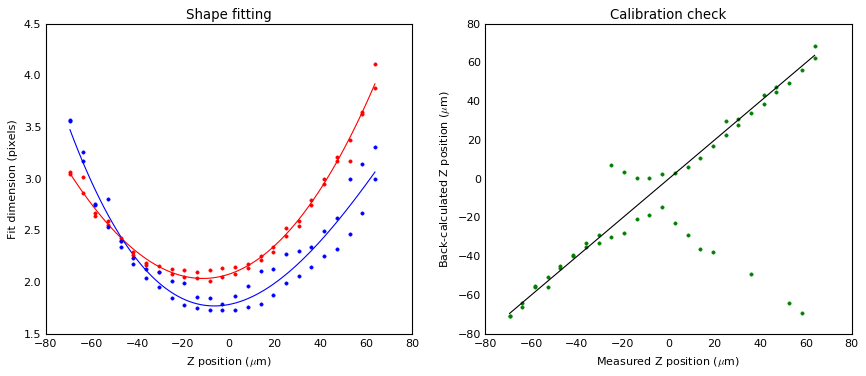

In [8]:
#### Least squares fitting to the width and height lines

start = time.time()
cal = sorted(zip(cal_dat.z, cal_dat.w, cal_dat.h), key = lambda x: x[0])
cal_pos, cal_w, cal_h = zip(*cal)

w_z = UnivariateSpline(np.r_[cal_pos], np.r_[cal_w], s=len(cal_pos))
h_z = UnivariateSpline(np.r_[cal_pos], np.r_[cal_h], s=len(cal_pos))

a0 = 0.3
pw0 = [-30., 10.]
ph0 = [30., 10.]
p0 = np.r_[a0, pw0, ph0] # [a, fw, bw, fh, bh]

plt.figure(num=None, figsize=(13, 5), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(1,2,1)
position = np.linspace(min(cal_pos), max(cal_pos), 80)
plt.plot(position, w_z(position), 'r-', position, h_z(position),'b-')
plt.plot(cal_pos, cal_w, 'r.')#, position, z_w(position, popt[0], popt[1:3]), 'r-')
plt.plot(cal_pos, cal_h, 'b.')#, position, z_h(position, popt[0], popt[3:5]), 'b-')
plt.xlabel('Z position ($\mu$m)')
plt.ylabel('Fit dimension (pixels)')
plt.title('Shape fitting')
plt.tick_params('both', bottom='off', top='off', right='off', left='off')
#plt.legend(('Width Fit', 'Height Fit', 'Width', 'Height'), loc=9)

### Define a function to fit z, given w and h
errFindZ = lambda z, w, h: np.r_[
    w_z(z)-w,
    h_z(z)-h
]
def findZ(w, h):
    if w+h < 5:
        z0 = -8.5
    elif w>h+0.5:
        z0 = 50
    else:
        z0 = -50
    foundZ = scipy.optimize.least_squares(errFindZ, z0, args = (w, h))
    if foundZ.success:
        return foundZ.x[0]
    print('Misfit!')
    return np.NaN

# Test it
found = []
for i in range(len(cal_w)):
    found.append(findZ(cal_w[i], cal_h[i]))
plt.subplot(1,2,2)
plt.plot(cal_pos, found, 'g.', cal_pos, cal_pos, 'k-')
plt.xlabel('Measured Z position ($\mu$m)')
plt.ylabel('Back-calculated Z position ($\mu$m)')
#plt.ylim(-220,230)
#plt.xlim(-220,230)
plt.title('Calibration check')
plt.tick_params('both', bottom='off', top='off', right='off', left='off')
#plt.savefig(trace_file_path+'20180720CY Calibration Figure.png')

end = time.time()
print('Time: ', end-start, ' s')
plt.show()

In [9]:
# Get particles from an individual image
def get_positions(file_path_complete, minCnt=5, minArea=5, span=25, maxDim=3.5,
                 intensity_thresh = 2):
    img = cv2.imread(file_path_complete,0)
    if type(img) != np.ndarray:
        print('Image file missing or corrupted.')
        return "Image missing or corrupted."
    ret,thresh = cv2.threshold(img,intensity_thresh,255,0) 
    #plt.imshow(thresh)
    #Get the threshold of the image
    _,contours,hierarchy = cv2.findContours(thresh, 1, 2) 
    #Get the contours from the thresholded image
    ok_contours = []
    ID = 0

    #For each contour check to see if it is a good contour 
    #and meets the area requirement.
    for cnt in contours:
        if(len(cnt) > minCnt):
            area = cv2.contourArea(cnt)
            if(area > minArea):
                x, y = findxy(cnt)
                if(x > span and y > span and x < len(img[0]) and y < len(img)):
                    # Collect its location
                    
                    img_small = cv2.resize(img, (0,0), fx=0.25, fy=0.25)
                    w, h = fit2D(img_small, int(x/4), int(y/4))
                    
                    
                    if (np.isnan(w+h)):
                        continue
                    if (0 < w < maxDim and 0 < h < maxDim):
                        z = findZ(w, h)
                        if (np.isnan(z)):
                            continue
                        ok_contours.append([x, y, z])

    return ok_contours

In [10]:
# Test it

path = '/Users/cyamanishi3/Desktop/201902/Processed/QuickTest/'

data = []
data = get_positions('{}00057.tif'.format(path))

data

C:\Users\cyamanishi3\AppData\Local\Continuum\anaconda3\envs\cv3.1\lib\site-packages\scipy\interpolate\fitpack2.py:222: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



[[504.7631530761719, 433.5, -41.073245017793774],
 [493.5, 393.5, -46.50608743331955],
 [451.5, 323.5, -28.573092800231514],
 [459.5, 287.5, -41.297747019442042],
 [413.5, 189.5, -7.9919179052127411]]

### Track particles

In [11]:
def trackParticles(file_path, 
                   Times=222, 
                   max_age=2,
                   max_jump_distance=80
                   ):
    #v7 track particles code
    particles = [] #Initialize the list of particles/objects to track
    x_scale = 1 # 0.67*8 #pixels per micron. 
                   #Used to check nearest neighbor approximations using cubic voxels.
    y_scale = 1 #0.63*8 #pixels per micron
    start = time.process_time()
    for t in range(1, Times):
        #Read in the images according to the file name
        file_type = ".tif"
        file_path_complete = file_path+str(t).zfill(5)+file_type
        ok_contours = []
        ok_contours = get_positions(file_path_complete)
        if ok_contours is None:
            continue
        matched_contours = []
        remaining_contours = []

        #For every existing object test it against the current found objects.
        #"Have object, where did it go?"
        for particle in particles:
            if particle.Age < max_age:
                (dt,dx,dy,dz) = particle.Positions[-1]
                did = particle.ID
                #print('old particle: ', did, int(dt), int(dx), int(dy), int(dz))

                #Find the closest
                distArray = []
                for idx, cnt in enumerate(ok_contours):
                    dist2 = ((dx-cnt[0])/x_scale)**2+((dy-cnt[1])/y_scale)**2+(dz-cnt[2])**2
                    distArray.append(dist2)
                #Sort the array according to distance
                sorteddata = sorted(zip(distArray, ok_contours), key=lambda x: x[0], reverse=False)

                if sorteddata != []:
                    #Assign it
                    #find the nth closest contour [n-1][1], in this case 1
                    closestcontour = sorteddata[0][1]
                    closestdist = sorteddata[0][0]
                    #print('contour: ', closestcontour)
                    #print('index: ', closestdist)
                    if closestdist < max_jump_distance:
                        particle.Positions.append([t, *closestcontour])
                        matched_contours.append(closestcontour)
                        #find closest contour in ok_contours and delete it

                        for idx, i in enumerate(ok_contours):
                            if i == closestcontour:
                                ok_contours.pop(idx)
                                #print('found '+str(idx))
                        particle.Age = 0
                        continue
                particle.Age = particle.Age+1
        remaining_contours= copy.deepcopy(ok_contours)
        pop_count = 0
        #print("ok_contours: ",ok_contours)
        for idx, i in enumerate(ok_contours): 
            #Identify matched contours and remove them
            found = 0
            for idy, j in enumerate(matched_contours):
                if i == j:
                    found = 1
            if found == 1:
                remaining_contours.pop(idx-pop_count)
                pop_count = pop_count+1
        for remaining in remaining_contours:
            num_particles = len(particles)+1
            particles.append(Particle(num_particles, *remaining, t))
    end = time.process_time()
    print('Time: ', end-start, ' s')
    return particles

### 3D Plot of traces

In [12]:
def writeReducedData(particles,trace_file_path, trace_file_name,
                     minlength=500):
    New_data = []
    Ages = []
    Reduced_data = np.empty([1, 5])
    Temp_data = np.empty([1, 4])
    Hit_count = 0
    if len(particles) is 0:
        return 0
    for idx, particle in enumerate(particles):
        #print(idx)
        Temp_data = np.asarray(particle.Positions)
        length = len(Temp_data)
        #print(length)
        Ages.append(length)
        if length >= minlength:
            id_array = np.empty([length,1])
            id_array.fill(particle.ID)
            Temp_data = np.concatenate((id_array, Temp_data),axis=1)
            Reduced_data = np.concatenate((Reduced_data, Temp_data), axis=0)
            Hit_count = Hit_count + 1
    Reduced_data = np.delete(Reduced_data, 0, 0)
    print('Number of particles: '+str(idx)) #total number of particles
    plt.hist(Ages,bins=30)
    plt.xlabel('Particle age (frames)')
    plt.ylabel('Number of particles')
    ind = np.lexsort((Reduced_data[:,0],Reduced_data[:,1]))    
    #print(type(ind))
    Reduced_data[ind]
    #print(Reduced_data)
    print('Long traces: '+str(Hit_count))
    thefile = open(trace_file_path+trace_file_name, 'w')
    for item in Reduced_data:
        thefile.write('{},{},{},{},{}\n'.format(
            int(item[0]),int(item[1]),item[2],item[3],item[4]
            ))
    return Reduced_data

In [13]:
#Take a slice
def cutData(data, xmin=None, xmax=None, ymin=None, 
            ymax=None, zmin=None, zmax=None, tmin=None, 
            tmax=None):
    slice_data = data
    if xmin is not None:
        slice_data = slice_data[slice_data[:,2]>xmin,:]
    if xmax is not None:
        slice_data = slice_data[slice_data[:,2]<xmax,:]
    if ymin is not None:
        slice_data = slice_data[slice_data[:,3]>ymin,:]
    if ymax is not None:
        slice_data = slice_data[slice_data[:,3]<ymax,:]
    if zmin is not None:
        slice_data = slice_data[slice_data[:,4]>zmin,:]
    if zmax is not None:
        slice_data = slice_data[slice_data[:,4]<zmax,:]
    if tmin is not None:
        slice_data = slice_data[slice_data[:,1]>tmin,:]
    if tmax is not None:
        slice_data = slice_data[slice_data[:,1]<tmax,:]
    return slice_data



In [14]:
def plot3d(data, cdim=1):
    plotly.offline.init_notebook_mode()

    trace0 = Scatter3d(
        x=data[:, 2],
        y=521-data[:, 3],
        z=data[:, 4],
        marker=Marker(color=data[:,cdim], 
                      colorscale='Portland', 
                      
                      size=5),
        mode='markers'
    )

    data = Data([trace0])

    

    layout = Layout(
        margin=dict(
            l=0,
            r=0,
            b=0,
            t=0
        ),
        xaxis=dict(
            range=[0,696]),
        yaxis=dict(
            range=[0,520])
    )
    fig = Figure(data=data, layout = layout)
    plotly.offline.iplot(fig)

In [15]:
def runFilters201902(name, numImages):
    particles = trackParticles(
        '/Users/cyamanishi3/Desktop/201902/Processed/{}/'.format(name), 
        Times = numImages)
    print("Found {} particles".format(len(particles)))
    Reduced_data = writeReducedData(
        particles, trace_file_path = '/Users/cyamanishi3/Desktop/201902/',
        trace_file_name = '{}_trace_data.txt'.format(name),
        minlength = 1
        )


C:\Users\cyamanishi3\AppData\Local\Continuum\anaconda3\envs\cv3.1\lib\site-packages\scipy\interpolate\fitpack2.py:222: UserWarning:


The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.



Time:  10.171875  s
Found 490 particles
Number of particles: 489
Long traces: 490


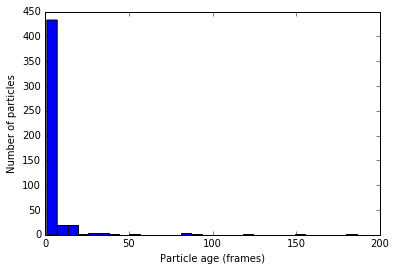

In [16]:


#runFilters201902(name='filter146', numImages=222)

runFilters201902(name='filter140', numImages=440)

In [17]:

# Read data for plotting

path = '/Users/cyamanishi3/Desktop/201902/'

data = []
data = np.loadtxt(
    open('{}filter140_trace_data.txt'.format(path),'rb'),
    delimiter=',',skiprows=0)

print(data[0:5,:])
# Rotate 31 degrees counterclockwise
# R = {cos, -sin, sin, cos}
angle = -38*np.pi/180
r = 0
for row in data:
    data[r,2:4] = np.matmul(row[2:4], [[np.cos(angle), -np.sin(angle)],
                               [np.sin(angle), np.cos(angle)]])
    r+=1
print(data[0:5,:])

[[   1.            1.          507.5         437.5         -49.42833073]
 [   1.            2.          507.5         437.5         -48.2397997 ]
 [   1.            3.          507.5         437.5         -46.79848669]
 [   1.            4.          507.5         437.5         -48.06190923]
 [   1.            5.          509.5         437.5         -46.09617293]]
[[   1.            1.          130.563562    657.20290343  -49.42833073]
 [   1.            2.          130.563562    657.20290343  -48.2397997 ]
 [   1.            3.          130.563562    657.20290343  -46.79848669]
 [   1.            4.          130.563562    657.20290343  -48.06190923]
 [   1.            5.          132.13958351  658.43422638  -46.09617293]]


In [18]:
#plot
def plotSlice(data, vmin=1, vmax=None, xdim=2, ydim=3, cdim=1, size=4):
    viridis = plt.cm.get_cmap('viridis')
    try:
        if vmax is None:
            color_norm = colors.Normalize(
                vmin=min(data[:,cdim]),vmax=max(data[:,cdim]))
            vmin=min(data[:,cdim])
            vmax=max(data[:,cdim])
        else:
            color_norm = colors.Normalize(vmin=vmin,vmax=vmax)
        scalar_map = cm.ScalarMappable(norm=color_norm, cmap=viridis)
        color_map = scalar_map.to_rgba(data[:,cdim])
    except ValueError:
        print('Value error, num beads = {}'.format(len(data)))
    
    fig = plt.scatter(data[:,xdim], data[:,ydim], 
                c=data[:,cdim], vmin=vmin, vmax=vmax, cmap=viridis, 
                edgecolors='None', s=size)
    lab = {2:'X', 3:'Y', 4:'Z'}
    plt.xlabel('{} ($\mu$m)'.format(lab.get(xdim)))
    plt.ylabel('{} ($\mu$m)'.format(lab.get(ydim)))
    cbar = plt.colorbar(fig)
    clab = {1:"Time (s)", 2:'X $\mu$m', 3: 'Y $\mu$m', 4: 'Z $\mu$m'}
    cbar.set_label('{}'.format(clab.get(cdim)))




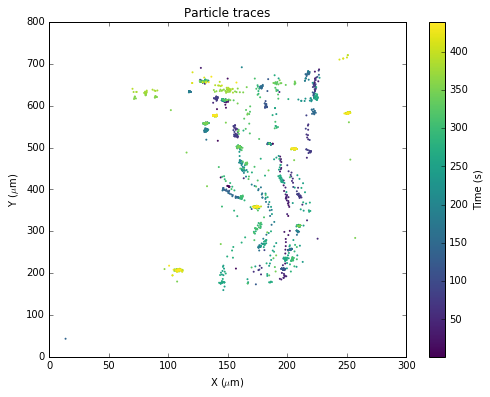

In [29]:
xmin = None
xmax=None
ymin = None
ymax = None
zmin= -150
zmax = 150
t1 = cutData(data, tmin=None, tmax=500, zmin=zmin, xmin=xmin, xmax=xmax,
            ymin=ymin, ymax=ymax) 
#t2 = cutData(data, tmin=1800, tmax=3600, zmin=zmin, xmin=xmin, xmax=xmax)
#t3 = cutData(data, tmin=4000, tmax=9000, zmin=zmin, xmin=xmin, xmax=xmax)


plt.figure(figsize=(8,6))
#plt.subplot(2,3,1)
plt.title('Particle traces')
#plotSlice(t1, vmax=None, dim=2)
#plt.ylim(-60,75)
#plt.xlim(200,1400)
#plt.subplot(2,3,2)
#plt.title('2 hours to 5 hours')
#plotSlice(t2, vmax=9000, dim=2)
#plt.subplot(2,3,3)
#plt.title('5 hours to 12 hours')
#plotSlice(t3, vmax=9000, dim=2)
#plt.subplot(2,3,4)
plotSlice(t1, vmax=None, xdim=2, cdim=1)
#plt.subplot(2,3,5)
#plotSlice(t2, vmax=9000, dim=3)
#plt.subplot(2,3,6)
#plotSlice(t3, vmax=9000, dim=3)

plt.savefig("{}BackflushAllTimes.png".format(path),format='png')


In [20]:
255-218

37

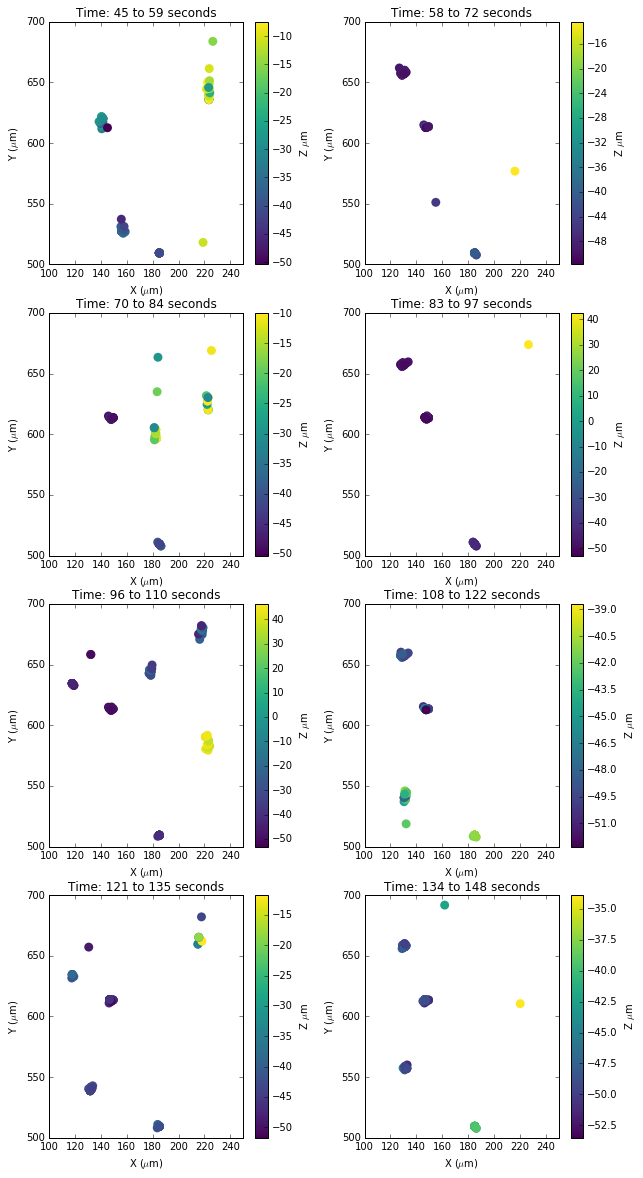

In [28]:
plt.figure(figsize=(10,20))
t = 68 # 68 is another good starting spot
t_step = 19
for i in range(1,9):
    plt.subplot(4,2,i)
    section = cutData(data, tmin=t, tmax=t+t_step, 
                      ymin=500, ymax=750,
                      zmin=-150, zmax=150) 
    t+=t_step
    plotSlice(section, xdim=2, ydim=3, cdim=4, size=80)
    plt.ylim(500, 700)
    plt.xlim(100, 250)
    plt.title("Time: {} to {} seconds".format(
        #int(t-t_step), int(t)))
        int(t/1.5-t_step/1.5), int(t/1.5+1.5)))
plt.subplots_adjust(wspace=0.3)
plt.savefig("{}BackflushXYZ.png".format(path),format='png')

In [23]:
plot3d(t1, cdim=0)